# Atlas-level integration of lung data

An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the [scIB manuscript](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2). The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [ ]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

In [ ]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.3.0

```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [ ]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

### Dataset Preprocessing
For this tutorial we use an already preprocessed dataset from the lung atlas integration task in the [scIB manuscript](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2). To see the exact preprocessing that was done, or to preprocess your own scRNA dataset for use with scvi-tools models, see our [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing).

In [ ]:
# download preprocessed dataset
adata_path = os.path.join(save_dir.name, "lung_atlas_preprocessed.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/52859312",
)
adata

  0%|          | 0.00/628M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
- Create an SCVI model object.

In [ ]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

/usr/local/lib/python3.11/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

In [ ]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

Now we train scVI. This should take a couple of minutes on a Colab session

In [ ]:
model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/246 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=246` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=246` reached.


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

Finally, we can cluster the dataset and visualize it the scVI latent space.

In [ ]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

<ipython-input-11-3d3b49bc4964>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


To visualize the scVI's learned embeddings, we use UMAP.

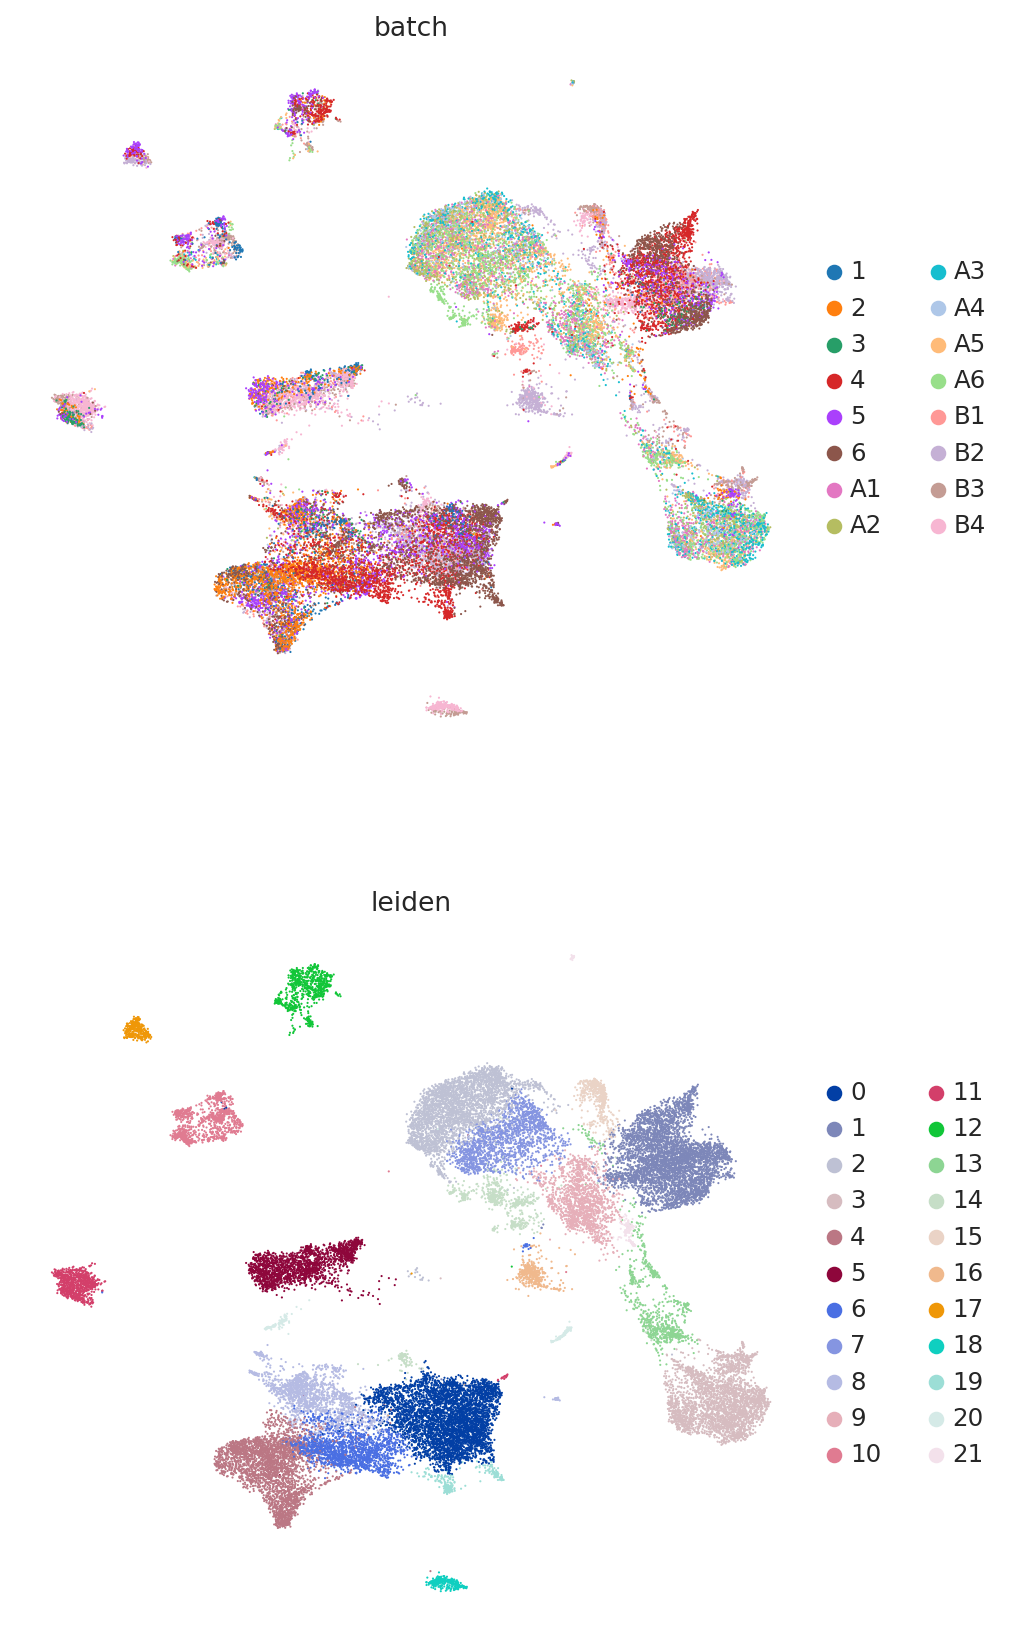

In [ ]:
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

Because this data has been used for benchmarking, we have access here to curated annotations. We can use those to assess whether the integration worked reasonably well.

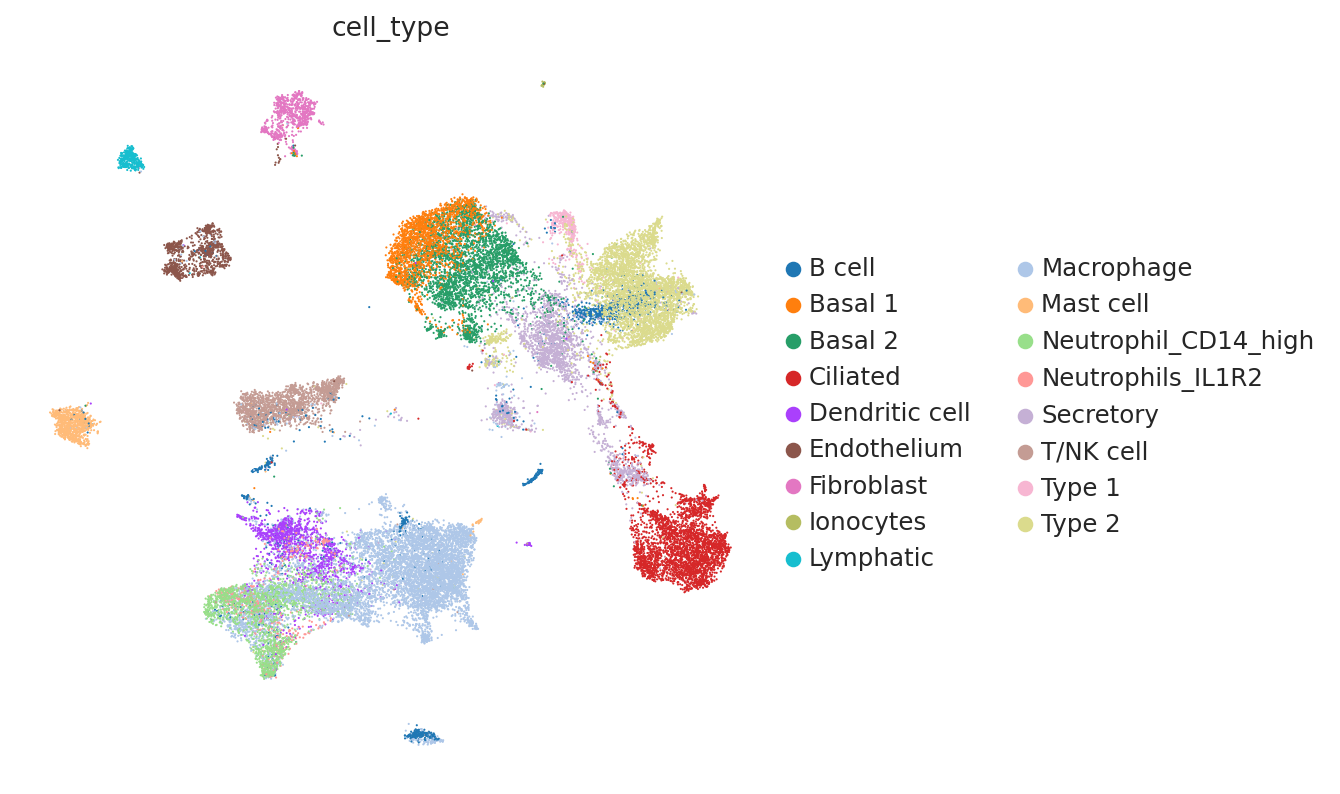

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

At a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. We see that this dataset is quite complex, where only some batches contain certain cell types.

Below we quantify the performance.

## Integration with scANVI

Previously, we used scVI as we assumed we did not have any cell type annotations available to guide us. Consequently, after the previous analysis, one would have to annotate clusters using differential expression, or by other means.

Now, we assume that all of our data is annotated. This can lead to a more accurate integration result when using scANVI, i.e., our latent data manifold is better suited to downstream tasks like visualization, trajectory inference, or nearest-neighbor-based tasks. scANVI requires:

- the sample identifier for each cell (as in scVI)
- the cell type/state for each cell

scANVI can also be used for label transfer and we recommend checking out the other scANVI tutorials to see explore this functionality.

Since we've already trained an scVI model on our data, we will use it to initialize scANVI.  When initializing scANVI, we provide it the `labels_key`. As scANVI can also be used for datasets with partially-observed annotations, we need to give it the name of the category that corresponds to unlabeled cells. As we have no unlabeled cells, we can give it any random name that is not the name of an exisiting cell type.

```{important}
scANVI should be initialized from a scVI model pre-trained on the same exact data.
```

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

/usr/local/lib/python3.11/dist-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [ ]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Now we can retrieve the latent space

In [ ]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

Again, we may visualize the latent space as well as the inferred labels

In [ ]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

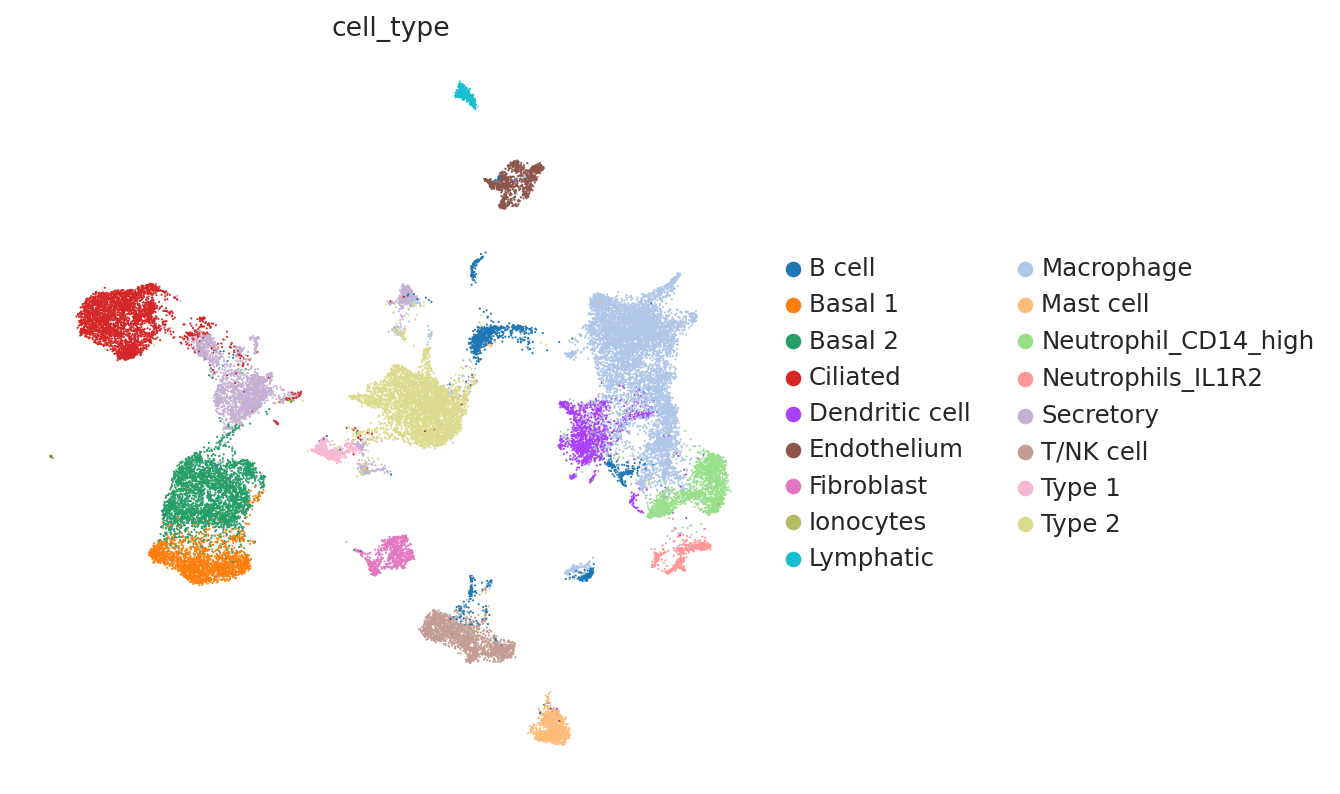

In [ ]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

### Compute integration metrics

Here we use the [scib-metrics](https://scib-metrics.readthedocs.io/en/stable/) package, which contains scalable implementations of the metrics used in the scIB benchmarking suite. We can use these metrics to assess the quality of the integration.

We can see that the additional training with label information and scANVI improved the metrics that capture bio conservation (`cLISI, Silhouette labels`) without sacrificing too much batch correction power (`iLISI, Silhouette batch`)

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

TypeError: Benchmarker.__init__() missing 2 required positional arguments: 'bio_conservation_metrics' and 'batch_correction_metrics'

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
df = bm.get_results(min_max_scale=False)
print(df)